<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 14:54:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 174kB 47.3MB/s 
     |████████████████████████████████| 143kB 34.8MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: wgk7jvi8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/wgk7jvi8


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: 5jr8i9br with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 25s 127ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1772 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0852
Epoch 2/100
16/16 [==============================] - 1s 64ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0711 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0892
Epoch 3/100
16/16 [==============================] - 1s 64ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0622 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0912
Epoch 4/100
16/16 [==============================] - 1s 61ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0533 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0813
Epoch 5/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0058 - mean_square

epoch,77
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.03008
val_loss,0.0085
val_mean_squared_error,0.0085
val_mean_absolute_error,0.07217
_runtime,113
_timestamp,1626188223
_step,77
best_val_loss,0.00799


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇▅▄▄█▄▄▅▄▄▅▃▃▃▄▃▃▄▂▂▃▂▂▂▂▂▂▂▆▂▁▁▂▁▁▂▂▂▂
val_mean_squared_error,▆▇▅▄▄█▄▄▅▄▄▅▃▃▃▄▃▃▄▂▂▃▂▂▂▂▂▂▂▆▂▁▁▂▁▁▂▂▂▂
val_mean_absolute_error,▇█▅▄▄█▄▄▅▄▅▅▃▃▄▅▃▃▅▂▂▃▂▃▂▂▂▂▃▆▂▁▂▂▁▁▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p7dvnbt9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 113ms/step - loss: 0.1397 - mean_squared_error: 0.1397 - mean_absolute_error: 0.2949 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1805
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1125 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1058
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0833 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0876
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0576 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0808
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.00

epoch,99
loss,0.00135
mean_squared_error,0.00135
mean_absolute_error,0.02821
val_loss,0.00651
val_mean_squared_error,0.00651
val_mean_absolute_error,0.06249
_runtime,18
_timestamp,1626188306
_step,99
best_val_loss,0.00651


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4wtb0kuu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 178ms/step - loss: 0.1223 - mean_squared_error: 0.1223 - mean_absolute_error: 0.2783 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1261
Epoch 2/200
8/8 [==============================] - 1s 69ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1280 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1110
Epoch 3/200
8/8 [==============================] - 1s 66ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1079 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0874
Epoch 4/200
8/8 [==============================] - 0s 61ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0837 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0765
Epoch 5/200
8/8 [==============================] - 1s 68ms/step - loss: 0.0084 - mean_squared_error: 0.

epoch,13
loss,0.00404
mean_squared_error,0.00404
mean_absolute_error,0.04795
val_loss,0.01144
val_mean_squared_error,0.01144
val_mean_absolute_error,0.08351
_runtime,15
_timestamp,1626188341
_step,13
best_val_loss,0.00981


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▁▁▁▁▁▂▂▂▂
val_mean_squared_error,█▅▃▁▁▁▁▁▁▁▂▂▂▂
val_mean_absolute_error,█▆▃▁▁▁▁▁▁▁▂▂▂▂
_runtime,▁▁▂▂▃▃▄▄▅▆▆▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: t08l0dq8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 4s 56ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - mean_absolute_error: 0.3671 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - val_mean_absolute_error: 0.2117
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - mean_absolute_error: 0.2036 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1518
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1473 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1474
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1505 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1471
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0301 - mean_squared_err

epoch,99
loss,0.00512
mean_squared_error,0.00512
mean_absolute_error,0.05141
val_loss,0.01019
val_mean_squared_error,0.01019
val_mean_absolute_error,0.07883
_runtime,45
_timestamp,1626188396
_step,99
best_val_loss,0.01016


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n051dgel with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 5s 34ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - mean_absolute_error: 0.2943 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1015
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0842 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0890
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0710 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0899
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0648 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0862
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_

epoch,195
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02482
val_loss,0.00526
val_mean_squared_error,0.00526
val_mean_absolute_error,0.05545
_runtime,74
_timestamp,1626188484
_step,195
best_val_loss,0.00524


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▇▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▇▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jx8kwcno with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 6s 92ms/step - loss: 0.0658 - mean_squared_error: 0.0658 - mean_absolute_error: 0.1889 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0808
Epoch 2/50
32/32 [==============================] - 2s 65ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0667 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0807
Epoch 3/50
32/32 [==============================] - 2s 64ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0598 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0812
Epoch 4/50
32/32 [==============================] - 2s 65ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0566 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0773
Epoch 5/50
32/32 [==============================] - 2s 66ms/step - loss: 0.0063 - mean_squared_error

epoch,49
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03218
val_loss,0.00597
val_mean_squared_error,0.00597
val_mean_absolute_error,0.05973
_runtime,114
_timestamp,1626188624
_step,49
best_val_loss,0.00597


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇▆▆█▅▅▅▆▄▅▄▄▄▄▃▃▃▃▃▃▃▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_squared_error,▇▇▇▆▆█▅▅▅▆▄▅▄▄▄▄▃▃▃▃▃▃▃▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,▇▇▇▆▇█▅▅▅▆▅▆▄▄▄▄▄▄▄▄▃▃▃▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h8d5wnvw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 126ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.2121 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0850
Epoch 2/50
16/16 [==============================] - 1s 71ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0826 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0829
Epoch 3/50
16/16 [==============================] - 1s 64ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0846 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0795
Epoch 4/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0654 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0787
Epoch 5/50
16/16 [==============================] - 1s 69ms/step - loss: 0.0066 - mean_squared_erro

epoch,24
loss,0.00346
mean_squared_error,0.00346
mean_absolute_error,0.04456
val_loss,0.01061
val_mean_squared_error,0.01061
val_mean_absolute_error,0.08034
_runtime,36
_timestamp,1626188672
_step,24
best_val_loss,0.01036


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▃▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁
val_loss,▄▃▂▁▂▁▁▂▄█▂▄▂▂▁▂▁▃▁▂▃▂▁▁▁
val_mean_squared_error,▄▃▂▁▂▁▁▂▄█▂▄▂▂▁▂▁▃▁▂▃▂▁▁▁
val_mean_absolute_error,▄▃▁▁▂▁▁▁▄█▁▃▂▁▁▂▁▃▂▂▃▂▁▂▂
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 3cg5kw02 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 6s 122ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1640 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0776
Epoch 2/200
16/16 [==============================] - 1s 67ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0577 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0760
Epoch 3/200
16/16 [==============================] - 1s 70ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0528 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0747
Epoch 4/200
16/16 [==============================] - 1s 68ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0935
Epoch 5/200
16/16 [==============================] - 1s 72ms/step - loss: 0.0085 - mean_squared

epoch,74
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02875
val_loss,0.00589
val_mean_squared_error,0.00589
val_mean_absolute_error,0.0597
_runtime,94
_timestamp,1626188788
_step,74
best_val_loss,0.00571


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▄▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▄▃▄▆▃▂▂▆▄▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▅▄█▄▃▄▆▃▂▂▆▄▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▅▅█▄▄▅▆▃▃▃▆▅▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 07u68ppk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 5s 122ms/step - loss: 0.1905 - mean_squared_error: 0.1905 - mean_absolute_error: 0.3742 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1800
Epoch 2/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1647 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1738
Epoch 3/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1775 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1600
Epoch 4/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1592 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1504
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 0.0341 - mean_squared

epoch,83
loss,0.00471
mean_squared_error,0.00471
mean_absolute_error,0.05044
val_loss,0.0101
val_mean_squared_error,0.0101
val_mean_absolute_error,0.07756
_runtime,102
_timestamp,1626188955
_step,83
best_val_loss,0.01004


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: atys8rvc with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 6s 93ms/step - loss: 0.0867 - mean_squared_error: 0.0867 - mean_absolute_error: 0.2054 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0999
Epoch 2/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0579 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0927
Epoch 3/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0463 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0902
Epoch 4/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0472 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0873
Epoch 5/50
32/32 [==============================] - 2s 67ms/step - loss: 0.0037 - mean_squared_error

epoch,49
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.02913
val_loss,0.0061
val_mean_squared_error,0.0061
val_mean_absolute_error,0.06034
_runtime,120
_timestamp,1626189087
_step,49
best_val_loss,0.00608


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁
val_mean_squared_error,█▇▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f60pz5gx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 6s 95ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2212 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1033
Epoch 2/100
32/32 [==============================] - 2s 69ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0735 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0813
Epoch 3/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0574 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0818
Epoch 4/100
32/32 [==============================] - 2s 68ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0528 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0820
Epoch 5/100
32/32 [==============================] - 2s 66ms/step - loss: 0.0045 - mean_squared_

epoch,11
loss,0.00338
mean_squared_error,0.00338
mean_absolute_error,0.04398
val_loss,0.01107
val_mean_squared_error,0.01107
val_mean_absolute_error,0.08251
_runtime,34
_timestamp,1626189134
_step,11
best_val_loss,0.01098


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▂▁▁▂▁▁▁
_runtime,▁▂▂▃▄▄▅▆▆▇▇█
_timestamp,▁▂▂▃▄▄▅▆▆▇▇█
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: jg8q3q55 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 186ms/step - loss: 0.1863 - mean_squared_error: 0.1863 - mean_absolute_error: 0.3759 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1675
Epoch 2/200
8/8 [==============================] - 1s 66ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1411 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1145
Epoch 3/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1011 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0886
Epoch 4/200
8/8 [==============================] - 1s 67ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0746 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0896
Epoch 5/200
8/8 [==============================] - 1s 71ms/step - loss: 0.0091 - mean_squared_error: 0.

epoch,199
loss,0.00251
mean_squared_error,0.00251
mean_absolute_error,0.03454
val_loss,0.00695
val_mean_squared_error,0.00695
val_mean_absolute_error,0.06365
_runtime,130
_timestamp,1626189288
_step,199
best_val_loss,0.00683


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xboaonzp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 5s 118ms/step - loss: 0.2023 - mean_squared_error: 0.2023 - mean_absolute_error: 0.3867 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1777
Epoch 2/50
16/16 [==============================] - 1s 71ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1600 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1758
Epoch 3/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1637 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1599
Epoch 4/50
16/16 [==============================] - 1s 66ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1492 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1484
Epoch 5/50
16/16 [==============================] - 1s 69ms/step - loss: 0.0281 - mean_squared_erro

epoch,49
loss,0.00381
mean_squared_error,0.00381
mean_absolute_error,0.04634
val_loss,0.01221
val_mean_squared_error,0.01221
val_mean_absolute_error,0.08651
_runtime,65
_timestamp,1626189386
_step,49
best_val_loss,0.01217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cfypxk2e with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 6s 95ms/step - loss: 0.0841 - mean_squared_error: 0.0841 - mean_absolute_error: 0.2205 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0945
Epoch 2/200
32/32 [==============================] - 2s 68ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0649 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0809
Epoch 3/200
32/32 [==============================] - 2s 67ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0472 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0809
Epoch 4/200
32/32 [==============================] - 2s 66ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0440 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0808
Epoch 5/200
32/32 [==============================] - 2s 70ms/step - loss: 0.0037 - mean_squared_

epoch,111
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02711
val_loss,0.00977
val_mean_squared_error,0.00977
val_mean_absolute_error,0.07736
_runtime,255
_timestamp,1626189678
_step,111
best_val_loss,0.00971


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jj7xeim6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 5s 120ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - mean_absolute_error: 0.3278 - val_loss: 0.0490 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1840
Epoch 2/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1584 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1399
Epoch 3/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1291 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1207
Epoch 4/100
16/16 [==============================] - 1s 68ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1065 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1033
Epoch 5/100
16/16 [==============================] - 1s 65ms/step - loss: 0.0103 - mean_squared

epoch,99
loss,0.00229
mean_squared_error,0.00229
mean_absolute_error,0.03617
val_loss,0.01019
val_mean_squared_error,0.01019
val_mean_absolute_error,0.07859
_runtime,122
_timestamp,1626189825
_step,99
best_val_loss,0.01017


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xfysbxiq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 5s 122ms/step - loss: 0.1525 - mean_squared_error: 0.1525 - mean_absolute_error: 0.3187 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1650
Epoch 2/50
16/16 [==============================] - 1s 79ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1337 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1062
Epoch 3/50
16/16 [==============================] - 1s 71ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0965 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0911
Epoch 4/50
16/16 [==============================] - 1s 70ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0775 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0822
Epoch 5/50
16/16 [==============================] - 1s 69ms/step - loss: 0.0085 - mean_squared_erro

epoch,19
loss,0.00508
mean_squared_error,0.00508
mean_absolute_error,0.0536
val_loss,0.01151
val_mean_squared_error,0.01151
val_mean_absolute_error,0.08326
_runtime,32
_timestamp,1626189899
_step,19
best_val_loss,0.01108


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ogzpbsip with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 126ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1489 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0763
Epoch 2/200
16/16 [==============================] - 1s 70ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0546 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0727
Epoch 3/200
16/16 [==============================] - 1s 72ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0443 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0701
Epoch 4/200
16/16 [==============================] - 1s 75ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0425 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0814
Epoch 5/200
16/16 [==============================] - 1s 70ms/step - loss: 0.0060 - mean_squared

epoch,49
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02445
val_loss,0.00595
val_mean_squared_error,0.00595
val_mean_absolute_error,0.06002
_runtime,67
_timestamp,1626189994
_step,49
best_val_loss,0.00567


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▃▂▄▂▃▂▂▂▃▂▁▂▂▂▂▁▂▁▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁
val_loss,▅▄▃▆▅▃▃▃▃▂▂▂█▂▂▂▃▃▂▃▂▂▁▂▂▃▁▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▄▃▆▅▃▃▃▃▂▂▂█▂▂▂▃▃▂▃▂▂▁▂▂▃▁▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▄▆▅▃▃▃▄▂▃▂█▂▂▂▃▃▃▂▂▂▂▂▂▃▁▂▂▂▁▂▂▁▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o4j87cmz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 6s 93ms/step - loss: 0.1530 - mean_squared_error: 0.1530 - mean_absolute_error: 0.3188 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1795
Epoch 2/200
32/32 [==============================] - 2s 69ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1656 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1579
Epoch 3/200
32/32 [==============================] - 2s 67ms/step - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1499 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1526
Epoch 4/200
32/32 [==============================] - 2s 71ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1342 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1461
Epoch 5/200
32/32 [==============================] - 2s 67ms/step - loss: 0.0282 - mean_squared_

epoch,75
loss,0.00296
mean_squared_error,0.00296
mean_absolute_error,0.0402
val_loss,0.00991
val_mean_squared_error,0.00991
val_mean_absolute_error,0.07679
_runtime,177
_timestamp,1626190185
_step,75
best_val_loss,0.00987


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xjfmcouq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 7s 112ms/step - loss: 0.1445 - mean_squared_error: 0.1445 - mean_absolute_error: 0.3029 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1062
Epoch 2/50
32/32 [==============================] - 2s 71ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0782 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0908
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0650 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0899
Epoch 4/50
32/32 [==============================] - 2s 70ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0641 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0901
Epoch 5/50
32/32 [==============================] - 2s 74ms/step - loss: 0.0059 - mean_squared_erro

epoch,49
loss,0.00265
mean_squared_error,0.00265
mean_absolute_error,0.03898
val_loss,0.00968
val_mean_squared_error,0.00968
val_mean_absolute_error,0.07547
_runtime,124
_timestamp,1626190351
_step,49
best_val_loss,0.0095


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▆▄▅▄▄█▃▄▄▃▃▃▃▂▂▂▃▄▃▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▂▁
val_mean_squared_error,█▅▅▅▆▄▅▄▄█▃▄▄▃▃▃▃▂▂▂▃▄▃▂▂▂▃▂▂▂▂▂▁▂▂▁▁▂▂▁
val_mean_absolute_error,█▄▄▄▆▄▅▄▄▇▃▃▄▃▃▃▃▂▂▂▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n6rvl0u5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 6s 96ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1510 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0814
Epoch 2/50
32/32 [==============================] - 2s 70ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0714 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1284
Epoch 3/50
32/32 [==============================] - 2s 74ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0656 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0874
Epoch 4/50
32/32 [==============================] - 2s 68ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0651 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0940
Epoch 5/50
32/32 [==============================] - 2s 71ms/step - loss: 0.0055 - mean_squared_error

epoch,25
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03589
val_loss,0.00975
val_mean_squared_error,0.00975
val_mean_absolute_error,0.07624
_runtime,68
_timestamp,1626190460
_step,25
best_val_loss,0.0086


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,▂█▃▃▃▂▂▂▂▃▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂█▃▃▃▂▂▂▂▃▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂█▃▄▄▂▂▂▂▄▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: skta9r7v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 6s 127ms/step - loss: 0.2467 - mean_squared_error: 0.2467 - mean_absolute_error: 0.4353 - val_loss: 0.1010 - val_mean_squared_error: 0.1010 - val_mean_absolute_error: 0.2551
Epoch 2/100
16/16 [==============================] - 1s 72ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2244 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1132
Epoch 3/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0881 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0825
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0568 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0821
Epoch 5/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0058 - mean_squared

epoch,99
loss,0.0028
mean_squared_error,0.0028
mean_absolute_error,0.03884
val_loss,0.00731
val_mean_squared_error,0.00731
val_mean_absolute_error,0.06544
_runtime,128
_timestamp,1626190603
_step,99
best_val_loss,0.00725


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1nlclhdr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 125ms/step - loss: 0.1234 - mean_squared_error: 0.1234 - mean_absolute_error: 0.2879 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1355
Epoch 2/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1196 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1004
Epoch 3/100
16/16 [==============================] - 1s 71ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0824 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0925
Epoch 4/100
16/16 [==============================] - 1s 74ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0718 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0795
Epoch 5/100
16/16 [==============================] - 1s 75ms/step - loss: 0.0062 - mean_squared

epoch,99
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03409
val_loss,0.00779
val_mean_squared_error,0.00779
val_mean_absolute_error,0.06827
_runtime,127
_timestamp,1626190745
_step,99
best_val_loss,0.00779


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: soc9v635 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 58ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - mean_absolute_error: 0.2952 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1375
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error: 0.1417 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0983
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0877 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0907
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0809 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0830
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0090 - mean_squared_e

epoch,199
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02349
val_loss,0.00548
val_mean_squared_error,0.00548
val_mean_absolute_error,0.05666
_runtime,48
_timestamp,1626190809
_step,199
best_val_loss,0.00548


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▄▄▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7gul133e with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 189ms/step - loss: 0.1502 - mean_squared_error: 0.1502 - mean_absolute_error: 0.3154 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1554
Epoch 2/200
8/8 [==============================] - 1s 75ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1521 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0888
Epoch 3/200
8/8 [==============================] - 1s 87ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0780 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0930
Epoch 4/200
8/8 [==============================] - 1s 77ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0774 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0836
Epoch 5/200
8/8 [==============================] - 1s 73ms/step - loss: 0.0070 - mean_squared_error: 0.

epoch,199
loss,0.00192
mean_squared_error,0.00192
mean_absolute_error,0.03242
val_loss,0.00654
val_mean_squared_error,0.00654
val_mean_absolute_error,0.06284
_runtime,134
_timestamp,1626190959
_step,199
best_val_loss,0.00633


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▅▄▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 23hhu4vh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 58ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - mean_absolute_error: 0.3279 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1618
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1559 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1505
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1458 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1446
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1391 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1361
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0248 - mean_squared_error: 

epoch,49
loss,0.00491
mean_squared_error,0.00491
mean_absolute_error,0.05
val_loss,0.01031
val_mean_squared_error,0.01031
val_mean_absolute_error,0.0793
_runtime,20
_timestamp,1626191010
_step,49
best_val_loss,0.01031


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qu419a8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 0.1028 - mean_squared_error: 0.1028 - mean_absolute_error: 0.2360 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1153
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1039 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0777
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0667 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0688
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0622 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0742
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.

epoch,14
loss,0.0027
mean_squared_error,0.0027
mean_absolute_error,0.03855
val_loss,0.00741
val_mean_squared_error,0.00741
val_mean_absolute_error,0.06728
_runtime,12
_timestamp,1626191037
_step,14
best_val_loss,0.00677


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁███████
_timestamp,▁▁▁▁▁▁▁▁███████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: oh81ndsz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 100,
        'hidden_size': 50,
        'learning_rate': 0.0005,
        'optimizer': 'Nadam',
        'activation': 'tanh',
    }

In [16]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='tanh'))
model.add(Dropout(0.2))
# hidden layer
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Nadam(learning_rate=0.0005)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  53751


In [17]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
40/40 [==============================] - 4s 7ms/step - loss: 0.1336
Epoch 2/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 4/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 5/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 6/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 7/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 8/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 9/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 10/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 11/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 12/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 13/200
40/40 [=================

In [18]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

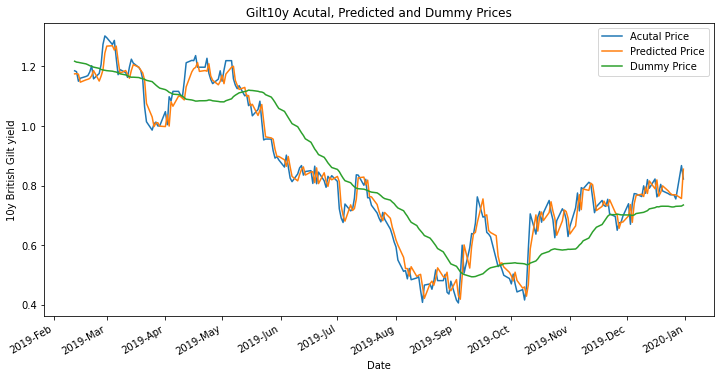

In [19]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

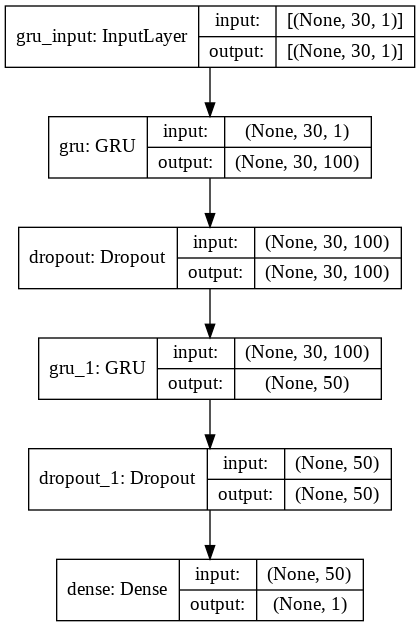

In [20]:
plot_model(model, show_shapes=True, expand_nested=True)

In [21]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.0028854783984903283
RMSE:  0.053716649174071984
MAE:  0.042850014948889216


In [22]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_Gilt10y/assets
